# Regresión logística aplicada a digits


## Examen


🛡️ INICIANDO PROTOCOLO BLINDADO V9 PARA: 'breast-w'
1. [Carga] Descargando dataset...
version 1
   -> Dimensiones: 699 filas, 9 columnas.
2. [Split] Separando Train/Test...
3. [Arquitectura] Configurando Pipeline...
4. [Optimización] Grid Search (Evitando configs prohibidas)...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
----------------------------------------------------------------------
MEJOR CONFIG (CV: 96.32%):
   {'classifier__C': 10, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
----------------------------------------------------------------------

NOTA FINAL: 99.05%

              precision    recall  f1-score   support

      benign       0.99      0.99      0.99       138
   malignant       0.99      0.99      0.99        72

    accuracy                           0.99       210
   macro avg       0.99      0.99      0.99       210
weighted avg       0.99      0.99      0.99       210



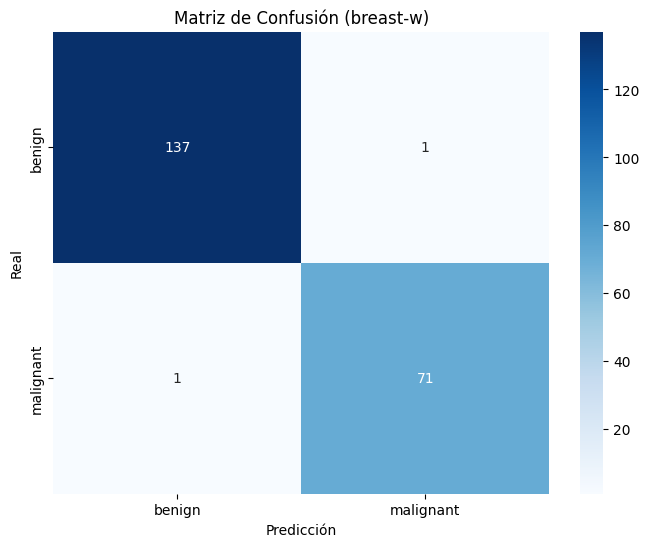

In [115]:
# ==============================================================================
# EXAMEN SISTEMAS INTELIGENTES: CLASIFICADOR FINAL
# ==============================================================================


NOMBRE_DATASET = "breast-w"

import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

#from sklearn.preprocessing import PolynomialFeatures

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MaxAbsScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Configuración limpia
warnings.filterwarnings("ignore")
np.random.seed(42)


print(f"🛡️ INICIANDO PROTOCOLO BLINDADO V9 PARA: '{NOMBRE_DATASET}'")
print("=" * 70)

try:
    # 1. CARGA

    print("1. [Carga] Descargando dataset...")

    dataset = fetch_openml(name=NOMBRE_DATASET, version=1, as_frame=True)


    print("version", dataset.details["version"])


    X = dataset.data
    y = dataset.target



    print(f"   -> Dimensiones: {X.shape[0]} filas, {X.shape[1]} columnas.")

    # Limpieza de target
    y = y.astype(str).to_numpy()

    # 2. SPLIT

    print("2. [Split] Separando Train/Test...")
    try:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, stratify=y, random_state=19
        )
    except ValueError:
        print("   ⚠️ Falló estratificación. Usando split simple.")
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, stratify=None, random_state=42
        )

    # 3. PIPELINE

    print("3. [Arquitectura] Configurando Pipeline...")

    numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X_train.select_dtypes(include=['object', 'bool', 'category']).columns


    try:
        # argumento nuevo
        OneHotEncoder(sparse_output=True)
        ohe_params = {'handle_unknown': 'ignore', 'sparse_output': True}
    except TypeError:
        # argumento viejo
        ohe_params = {'handle_unknown': 'ignore', 'sparse': True}



    '''numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('poly', PolynomialFeatures(degree=2, include_bias=False)), # <--- MAGIA AÑADIDA
        ('scaler', MaxAbsScaler())
    ])'''

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', MaxAbsScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(**ohe_params))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='drop'
    )

    clf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(random_state=42))
    ])

    # 4. GRID SEARCH

    print("4. [Optimización] Grid Search (Evitando configs prohibidas)...")


    param_grid = [

        {
            'classifier__solver': ['lbfgs'],
            'classifier__penalty': ['l2'],
            'classifier__C': [0.1, 1, 10],
            'classifier__class_weight': [None, 'balanced']
        },

        {
            'classifier__solver': ['liblinear'],
            'classifier__penalty': ['l1'],
            'classifier__C': [0.1, 1, 10],
            'classifier__class_weight': [None, 'balanced']
        }
    ]


    cv_folds = 3 if X.shape[0] > 10000 else 5

    search = GridSearchCV(clf, param_grid, cv=cv_folds, scoring='accuracy', n_jobs=-1, verbose=1)
    search.fit(X_train, y_train)

    print("-" * 70)
    print(f"MEJOR CONFIG (CV: {search.best_score_:.2%}):")
    print(f"   {search.best_params_}")
    print("-" * 70)

    # 5. EVALUACIÓN

    y_pred = search.predict(X_test)
    acc_final = accuracy_score(y_test, y_pred)

    print("=" * 70)
    print()
    print(f"NOTA FINAL: {acc_final:.2%}")
    print()
    print("=" * 70)


    print(classification_report(y_test, y_pred))

    # Gráfica
    try:
        cm = confusion_matrix(y_test, y_pred)
        try: labels = search.best_estimator_.named_steps['classifier'].classes_
        except: labels = np.unique(y)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
        plt.title(f"Matriz de Confusión ({NOMBRE_DATASET})")
        plt.ylabel('Real'); plt.xlabel('Predicción')
        plt.show()
    except Exception as e:
        print("No se pudo generar la gráfica.")

except Exception as e:
    print(f"\nERROR CRÍTICO: {e}")


#diabetes 20 80.95
#sonar 2 87.3
#adult 1 86.11
#ionosphere 16 92.45
#breast-w 19 99.05
#iris 19 100
#wine 24 100
#titanic 19 97.71
#heart-statlog 4 91.36
#credit-g 0 78.33
#spambase 16 94.06

